In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from collections import Counter
import random
import spacy 
nlp = spacy.load("en_core_web_md")

from scripts import utils
from scripts import documents as docs
from scripts import comparisons 
from scripts import comparisonsmachine as machine

data_folder = "data"
spotify_file = "spotify_articles.csv"
spotify_path = os.path.join(data_folder, spotify_file)

census_file = "census_articles.csv"
census_path = os.path.join(data_folder, census_file)

helsinki_file = "helsinki_articles.csv"
helsinki_path = os.path.join(data_folder, helsinki_file)

spotify_df = utils.readArticles(spotify_path)
census_df = utils.readArticles(census_path)
helsinki_df = utils.readArticles(helsinki_path)

In [2]:
helsinki_df.head()

,id,publisher,scrape_time,text,doc
0,6,nytimes.com,2018-07-15T07:54:28-04:00,Trump Plays Golf in Scotland Before Putin Summ...,None
1,35,dailymail.co.uk,2018-07-15T06:34:13-04:00,"Sunday, Jul 15th 2018 5-Day Forecast ### Adver...",None
2,57,newyorker.com,2018-07-16T09:10:56-04:00,Will Putin Spare Trump the Lecture He Has Give...,None
3,77,oregonlive.com,2018-07-16T10:19:40-04:00,Enter City and State or Zip Code ### Congratul...,None
4,106,bostonglobe.com,2018-07-16T03:33:28-04:00,The Boston Globe ### Scroll to top of page ###...,None


In [3]:
clust_levinson = [610, 3581, 6678]
clust_reuters = [761, 16223]
clust_ap = [8200, 8818, 9990]
clust_ap_files = [12769, 2313, 6190]
clust_freshair = [7042, 6644]
unique = [6754, 10053, 10250, 6146, 967, 15307, 15482, 604, 1766, 4738, 5906, 6844, 14721, 14730]
clust_wrong = [10254, 9090]
clust_snippet = [7624, 8985, 5289]
# 7624 = paraphrase of AP
# 8985 = briefing of many news stories, includes snippet from 6844
# 967 = not exactly copied from, but heavily based off of the original NYT report 
# 1766 = heavily based off of reuters 

In [4]:
dd = comparisons.DuplicationDetection()
dd.entities = True

doc_r1 = docs.Document(census_df.loc[census_df["id"] == 761, "text"].iloc[0])
doc_r2 = docs.Document(census_df.loc[census_df["id"] == 16223, "text"].iloc[0])
doc_ap1 = docs.Document(census_df.loc[census_df["id"] == 8200, "text"].iloc[0])
doc_ap2 = docs.Document(census_df.loc[census_df["id"] == 8818, "text"].iloc[0])
doc_w = docs.Document(census_df.loc[census_df["id"] == 10254, "text"].iloc[0])

doc_6844 = docs.Document(census_df.loc[census_df["id"] == 6844, "text"].iloc[0])
snip_8985 = docs.Document(census_df.loc[census_df["id"] == 8985, "text"].iloc[0])

Pairwise sentence jaccard indices between two unique vs. duplicate documents


Text(0.5, 1.0, 'Probability density histograms of pairwise sentence Jaccard indices')

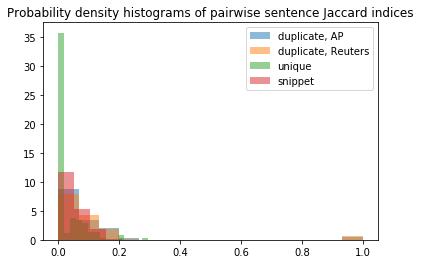

In [5]:
def hist(mat, density = True, alpha = 0.5, bins = 15):
    if len(np.shape(mat)) > 1:
        mat = utils.flatten(mat)
    plt.hist(mat, density = density, alpha = alpha, bins = bins)

print("Pairwise sentence jaccard indices between two unique vs. duplicate documents")

hist(dd.compute_jaccard_matrix(doc_ap1, doc_ap2))
hist(dd.compute_jaccard_matrix(doc_r1, doc_r2))
hist(dd.compute_jaccard_matrix(doc_r1, doc_w))
hist(dd.compute_jaccard_matrix(doc_6844, snip_8985))
plt.legend(["duplicate, AP", "duplicate, Reuters", "unique", "snippet"])
plt.title("Probability density histograms of pairwise sentence Jaccard indices")

C:\Users\v-lindo\anaconda3\lib\site-packages\numpy\lib\histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


No sentences pairs from the unique article pair was selected


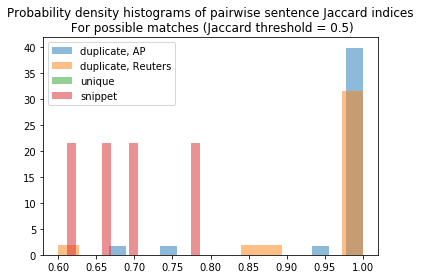

In [6]:
hist(dd.compute_jaccard_matrix(doc_ap1, doc_ap2)[np.where(dd.get_match_matrix() > 0)])
hist(dd.compute_jaccard_matrix(doc_r1, doc_r2)[np.where(dd.get_match_matrix() > 0)])
hist(dd.compute_jaccard_matrix(doc_r1, doc_w)[np.where(dd.get_match_matrix() > 0)])
hist(dd.compute_jaccard_matrix(doc_6844, snip_8985)[np.where(dd.get_match_matrix() > 0)])
plt.legend(["duplicate, AP", "duplicate, Reuters", "unique", "snippet"])
plt.title("Probability density histograms of pairwise sentence Jaccard indices\n For possible matches (Jaccard threshold = 0.5)")
print("No sentences pairs from the unique article pair was selected")

Since we see that many of the 'fuzzy' scores of 0.6-0.8 are from the snippet pair,
let's take a closer look at the example matches:

Article Similarity Score: 0.08181678084590707
(Weighted by Average Article Length: 0.048429153692311586 )


S 0 :  Immigration activists rallied outside the Supreme Court in April as the justices heard arguments over the Trump administration's plan to ask about citizenship on the 2020 census.(J. Scott Applewhite/Associated Press/File 2019) 

	T 65 0.7 0.67 :  Immigration activists rally outside the Supreme Court as the justices hear arguments over the Trump administration's plan to ask about citizenship on the 2020 census, in Washington. 

Jaccard Index: 0.696969696969697 with counts False
I: {'have', 'activist', 'in', 'about', 'plan', 'over', 'administration', 'outside', 'immigration', 'court', 'ask', 'trump', 'hear', 'the', 'on', 'rally', 'supreme', 'to', '2020', 'citizenship', 'a', 'argument', 'justice'}
A-B: {'scott', 'press', 'applewhite', 'associate

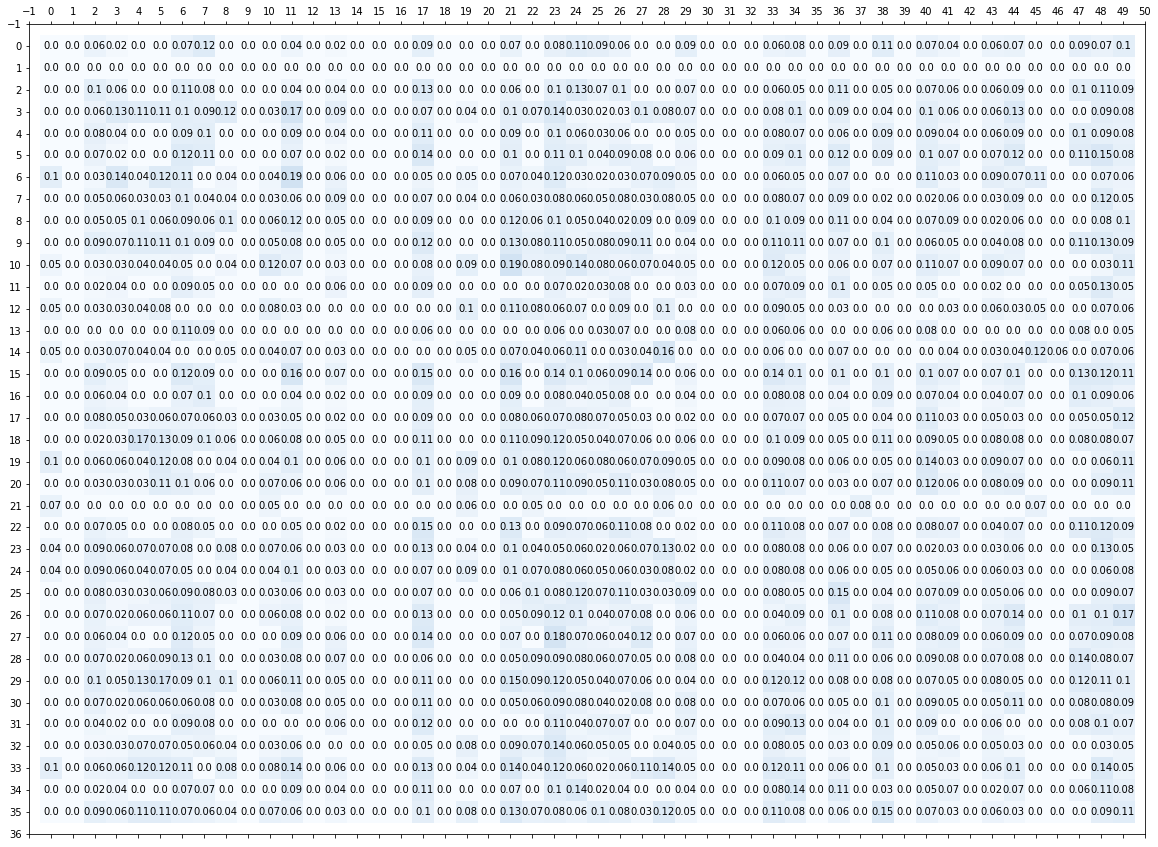

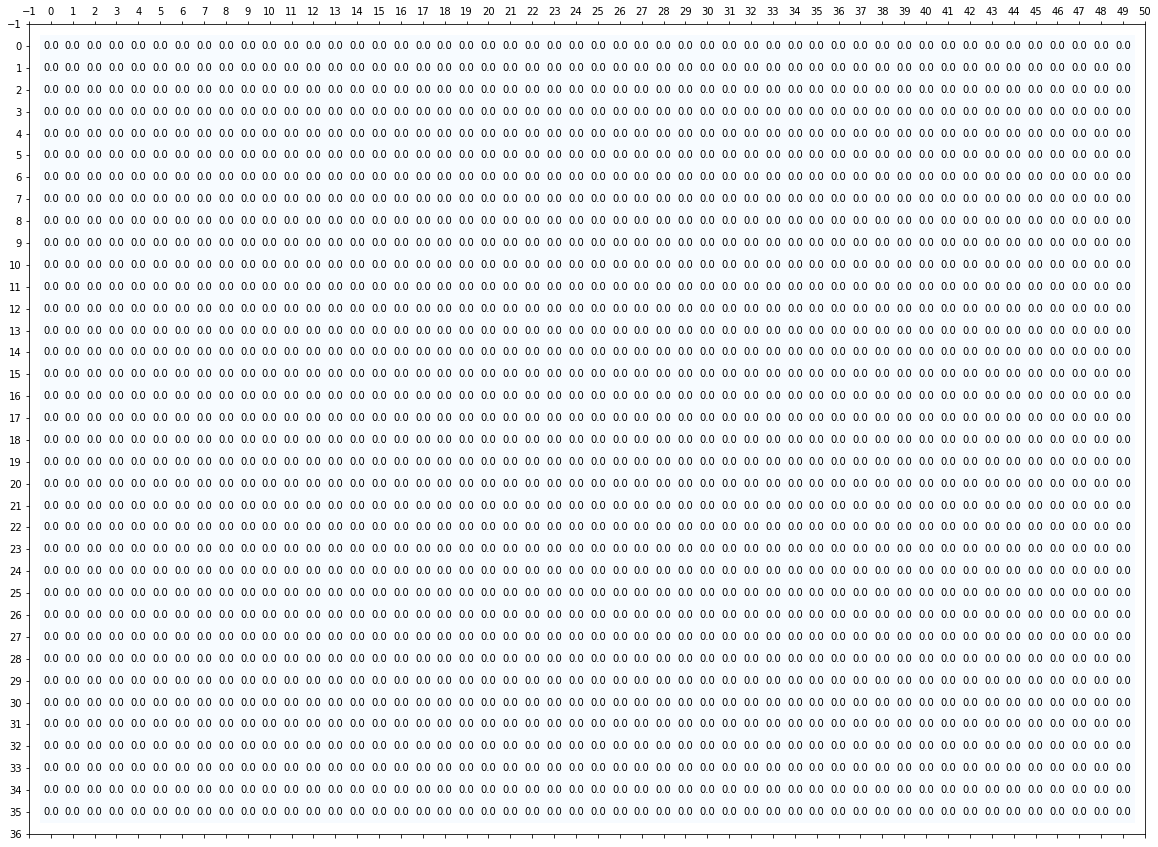

In [7]:
print("Since we see that many of the 'fuzzy' scores of 0.6-0.8 are from the snippet pair,\nlet's take a closer look at the example matches:")
jac_mat_snip = dd.compute_jaccard_matrix(doc_6844, snip_8985)
match_mat_snip = dd.get_match_matrix()
#ac.display_mat(match_mat_snip)

print("\nArticle Similarity Score:", dd.jaccard_score())
print("(Weighted by Average Article Length:", np.sum(jac_mat_snip * match_mat_snip)/np.mean(jac_mat_snip.shape), ")\n")
dd.print_sentence_matches(visualize = True)

utils.display_mat(jac_mat_snip)
utils.display_mat(match_mat_snip)

In [8]:
bow1 = doc_6844.get_bow_sentences()[0]
bow2 = snip_8985.get_bow_sentences()[65]
dd.jaccard_index(bow1, bow2, visualize = True)
print("\n")
dd.jaccard_index(doc_6844.sent_entities[0], snip_8985.sent_entities[65], visualize = True, union_subset=True)

Jaccard Index: 0.696969696969697 with counts False
I: {'have', 'activist', 'in', 'about', 'plan', 'over', 'administration', 'outside', 'immigration', 'court', 'ask', 'trump', 'hear', 'the', 'on', 'rally', 'supreme', 'to', '2020', 'citizenship', 'a', 'argument', 'justice'}
A-B: {'scott', 'press', 'applewhite', 'associated', '2019', 'census.(j.', 'april', 'file'} 
B-A: {'washington', 'census'}


Jaccard Index: 0.6666666666666666 with counts False
I: {'the supreme court', 'trump'}
A-B: {'scott applewhite'} 
B-A: {'washington'}


0.6666666666666666

0 of 17 rows completed, 0.01m elapsed
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping


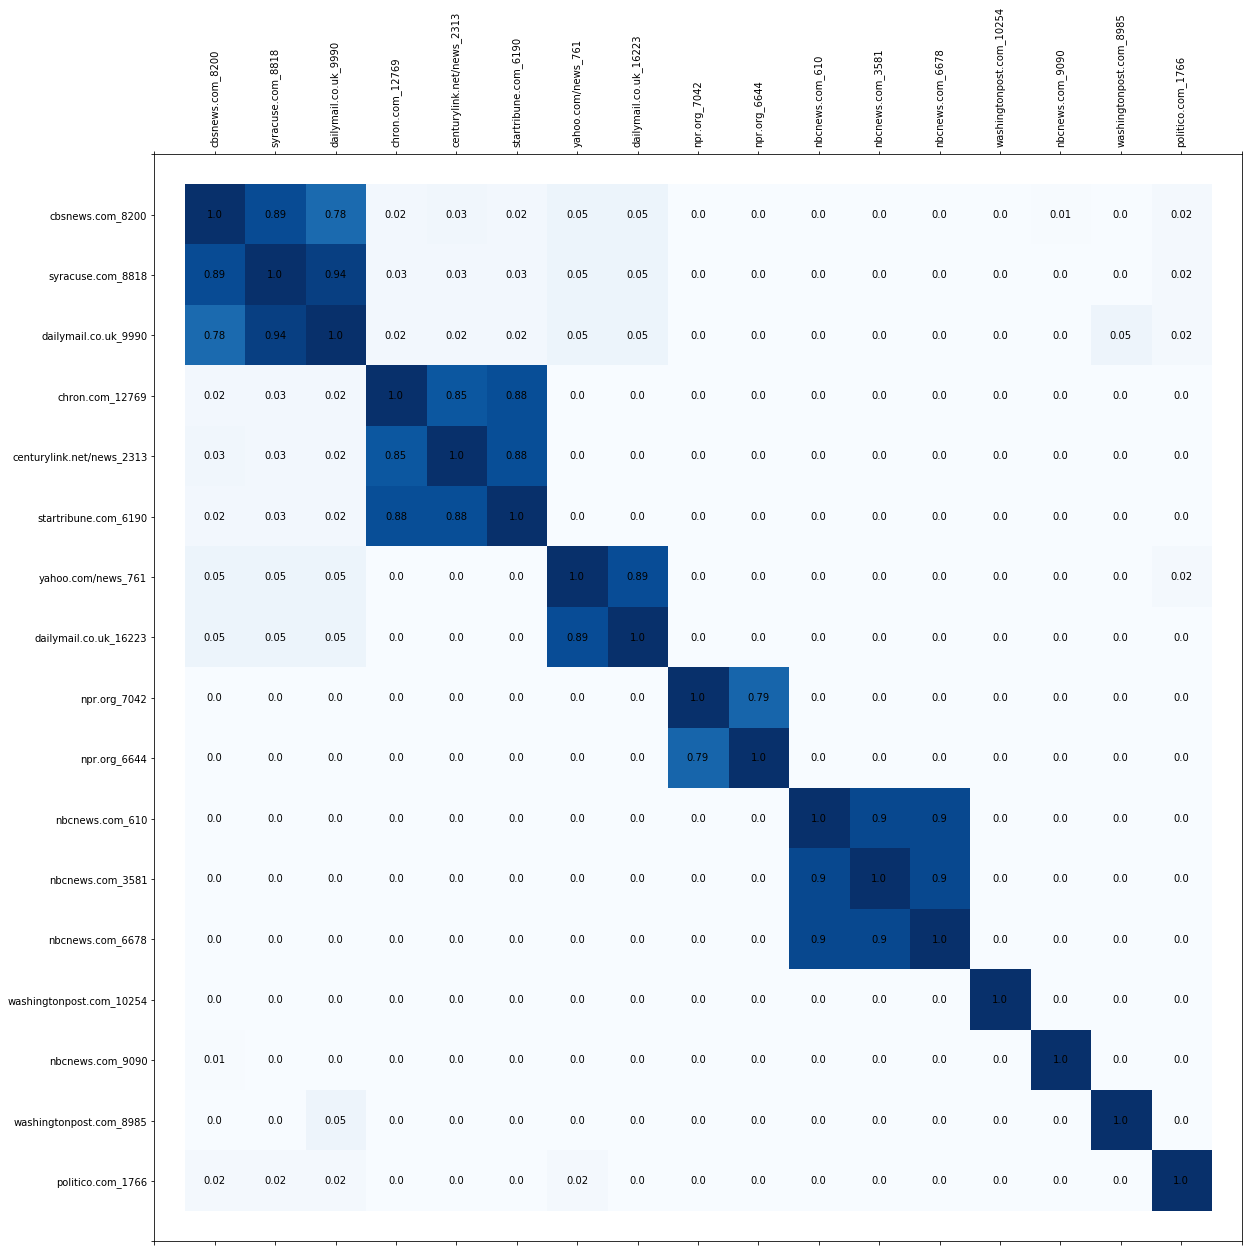

In [9]:
docs_list = clust_ap + clust_ap_files + clust_reuters + clust_freshair + clust_levinson + clust_wrong + [8985, 1766]
# 8985 = briefing of many news stories, includes snippet from 6844
# 1766 = heavily based off of reuters 
clusters_dict = dd.dict_by_ids(census_df, docs_list)

dd.entities = True
score_mat = dd.similarity_mat(clusters_dict, ordered = False)
axislabels = [census_df[census_df["id"] == id].iloc[0, 1] + "_" + str(id) for id in docs_list]
utils.display_mat(score_mat, xlabs = axislabels)


Article Similarity Score: 0.7762733720180529
(Weighted by Average Article Length: 0.7571644042232278 )


S 0 :  NEW YORK (AP) - 

	T 3 0.67 -1.0 :  NEW YORK  

Jaccard Index: 0.6666666666666666 with counts False
I: {'new', 'york'}
A-B: {'ap'} 
B-A: set()
Entities: 
-1

S 1 : A Republican redistricting expert advocated for adding a citizenship question to the 2020 census to give an electoral edge to white people and Republicans, opponents of the move alleged in a court filing Thursday. 

	T 4 1.0 -1.0 : A Republican redistricting expert advocated for adding a citizenship question to the 2020 census to give an electoral edge to white people and Republicans, opponents of the move alleged in a court filing Thursday. 

Jaccard Index: 1.0 with counts False
I: {'question', 'republican', 'in', 'allege', 'edge', 'file', 'people', 'advocate', 'opponent', 'court', 'the', 'add', 'redistricting', 'census', 'and', 'white', 'expert', 'for', 'give', 'to', '2020', 'thursday', 'move', 'citizenship', 'a

I: {'ho', 'question', 'letter', 'dale', 'have', 'american', 'sign', 'in', 'clear', 'civil', 'against', 'argue', 'before', '-pron-', 'apprise', 'late', 'high', 'court', 'may', 'case', 'though', 'liberties', 'not', 'who', 'the', 'add', 'by', 'and', 'if', 'vote', 'document', 'yet', 'top', 'project', 'group', 'director', 'hofeller', 'thursday', 'affect', 'a', 'union', 'lawyer', 'of', 'right', 'development'}
A-B: set() 
B-A: set()
Entities: 
Jaccard Index: 1.0 with counts False
I: {'the american civil liberties union', 'hofeller', 'dale ho'}
A-B: set() 
B-A: set()
1.0

S 13 :  States, cities and rights groups had sued in New York and elsewhere, arguing that the question would suppress the count of immigrants and strengthen congressional representation and funding for areas where mostly Republicans reside. 

	T 13 1.0 1.0 :  States, cities and rights groups had sued in New York and elsewhere, arguing that the question would suppress the count of immigrants and strengthen congressional repres

S 24 :  The Hofeller documents cited by lawyers were discovered when his estranged daughter found four external computer hard drives and 18 thumb drives in her father's Raleigh, North Carolina, home after his death last summer. 

	T 24 1.0 1.0 :  The Hofeller documents cited by lawyers were discovered when his estranged daughter found four external computer hard drives and 18 thumb drives in her father's Raleigh, North Carolina, home after his death last summer. 

Jaccard Index: 1.0 with counts False
I: {'have', 'last', 'in', 'when', 'cite', 'drive', 'raleigh', 'north', 'discover', 'external', 'home', 'hard', 'father', 'his', 'the', 'her', 'by', 'and', '18', 'find', 'carolina', 'be', 'document', 'estrange', 'hofeller', 'death', 'four', 'thumb', 'after', 'daughter', 'computer', 'lawyer', 'summer'}
A-B: set() 
B-A: set()
Entities: 
Jaccard Index: 1.0 with counts False
I: {'raleigh', 'last summer', 'hofeller', 'north carolina'}
A-B: set() 
B-A: set()
1.0

S 25 :  The New York Times report

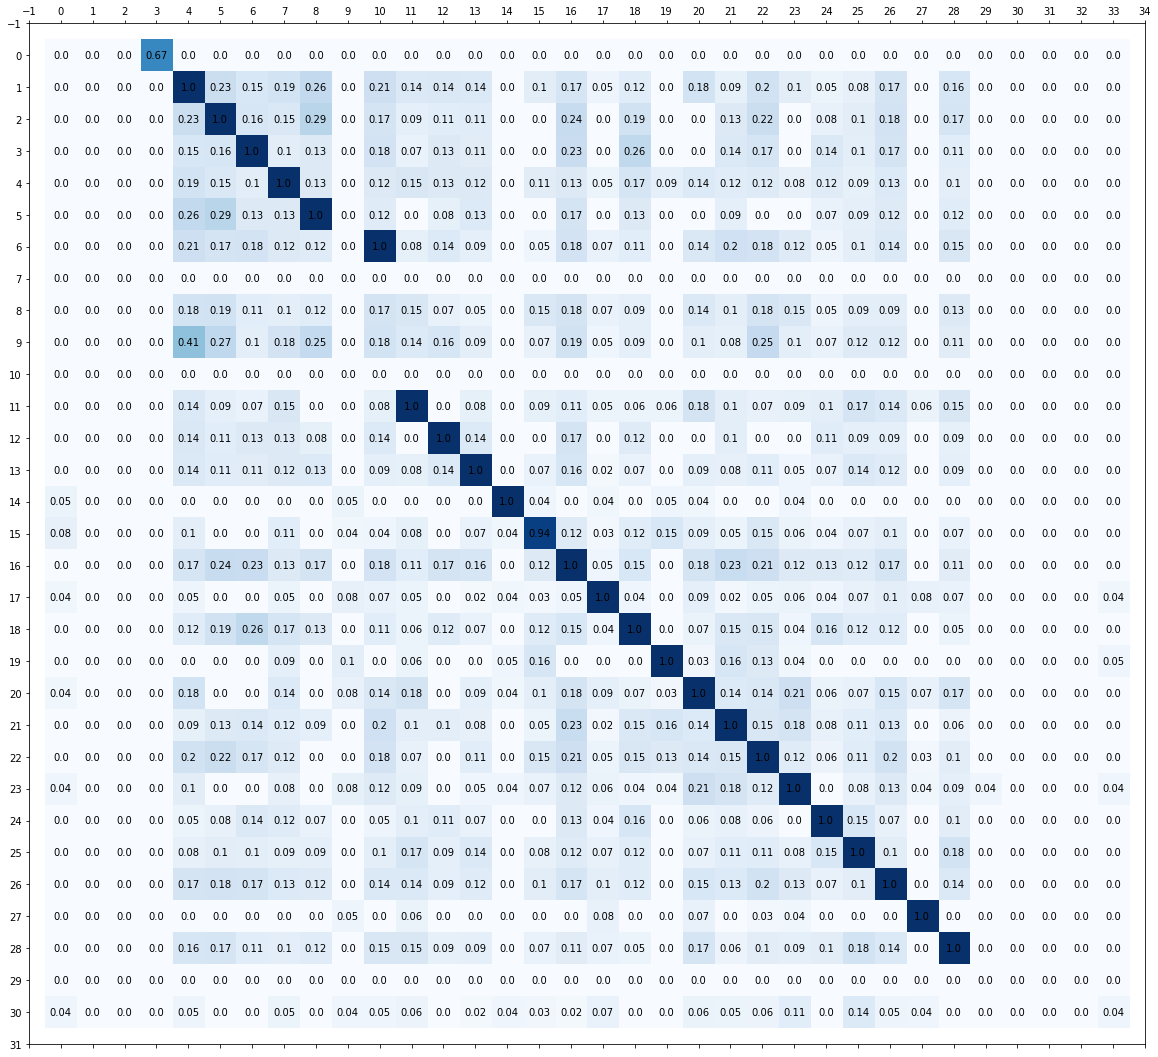

In [10]:
id1 = 9990
id2 = 8200
jac_mat = dd.compute_jaccard_matrix(clusters_dict[id1], clusters_dict[id2])
match_mat = dd.get_match_matrix()

print("\nArticle Similarity Score:", dd.jaccard_score())
print("(Weighted by Average Article Length:", np.sum(jac_mat * match_mat)/np.mean(jac_mat.shape), ")\n")
dd.print_sentence_matches(visualize=True)

utils.display_mat(jac_mat)

In [11]:
np.sum(match_mat, axis = 0), np.sum(match_mat, axis = 1)

(array([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]))

In [12]:
print(clusters_dict[id1].get_sentences()[6:10])
print("\n")
clusters_dict[id2].get_sentences()[7:13]

['The new evidence reveals that Dr. Thomas Hofeller, the longtime Republican redistricting specialist, played a significant role in orchestrating the addition of the citizenship question to the 2020 Decennial Census in order to create a structural electoral advantage for, in his own words, \'Republicans and Non-Hispanic Whites,\' and that defendants obscured his role through affirmative misrepresentations," the filing said.'
 ' The Justice Department denied those allegations in a statement released late Thursday, calling them an "an unfortunate last-ditch effort" to derail a U.S. Supreme Court decision on the legality of adding the citizenship question.'
 ' FILE -'
 "In this April 23, 2019 file photo, immigration activists rally outside the Supreme Court as the justices hear arguments over the Trump administration's plan to ask about citizenship on the 2020 census, in Washington."]




array([" Lawyers for opponents of adding the question said the files, found on Hofeller's computer drives after he died last year, also showed that he contributed vital language to a Justice Department letter used to justify the question on the grounds that it was needed to protect minority voting rights.",
       ' In reality, the lawyers argued, the documents show the census change is part of a wider Republican effort to restrict the political power of Democrats and Latino communities.',
       ' "',
       'The new evidence reveals that Dr. Thomas Hofeller, the longtime Republican redistricting specialist, played a significant role in orchestrating the addition of the citizenship question to the 2020 Decennial Census in order to create a structural electoral advantage for, in his own words, \'Republicans and Non-Hispanic Whites,\' and that defendants obscured his role through affirmative misrepresentations," the filing said.',
       ' How gerrymandering became one of the biggest is

In [13]:
clusters_dict[id2].sent_entities

array([list([]), list([]), list([]), list([]), list([]),
       list(['manhattan', 'thomas hofeller', 'trump']),
       list(['hofeller', 'justice department']), list([]),
       list(['thomas hofeller']), list([]),
       list(['the justice department', 'late thursday', 'u.s. supreme court']),
       list(['spring 2018']),
       list(['hofeller', 'the american civil liberties union', 'dale ho']),
       list(['new york']), list([]), list(['trump']),
       list(['aclu', 'justice department', 'trump', 'hofeller']),
       list(['u.s.', 'jesse m. furman']),
       list(['ho', 'aclu', 'hofeller']), list([]),
       list(['furman', 'the justice department']),
       list(['the justice department', 'department of justice']),
       list(['department', 'december 2017']), list(['department']),
       list(['hofeller', 'raleigh', 'north carolina', 'last summer']),
       list(['the new york times', 'north carolina have', 'hofeller']),
       list(['furman']), list(['california', 'maryland'])

Entities similarity == 0, skipping
0 of 24 rows completed, 0.02m elapsed
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping


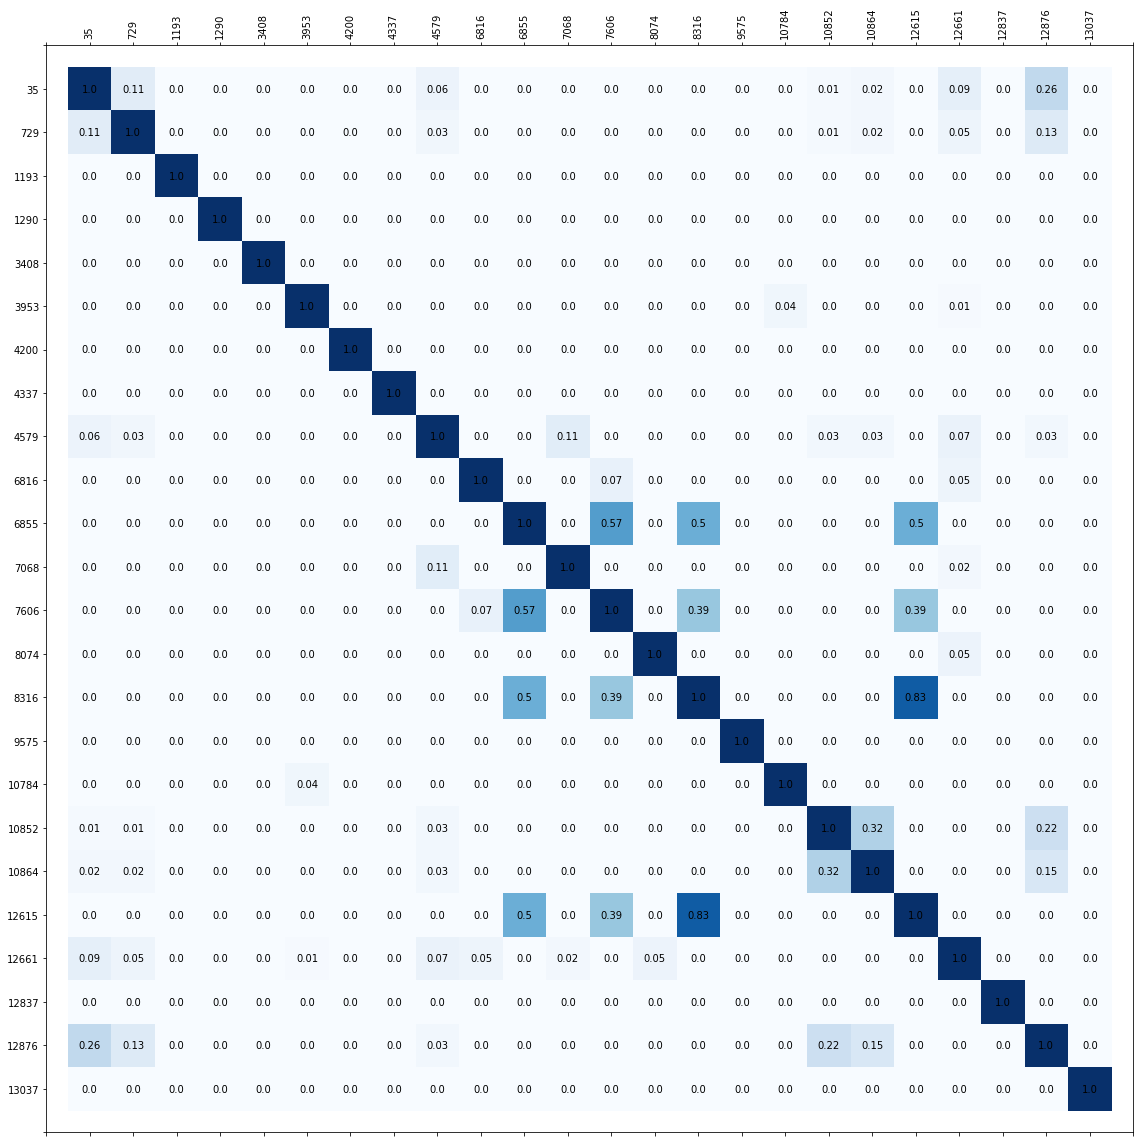

In [14]:
dm_ids = helsinki_df.loc[(helsinki_df["publisher"] == "dailymail.co.uk"), "id"]
dm_dict = dd.dict_by_ids(helsinki_df, dm_ids)

score_mat_dm = dd.similarity_mat(dm_dict)
axislabels = list(dm_dict.keys())
utils.display_mat(score_mat_dm, True, axislabels)

# 35, 729, and 12876 contain similar snippets as they are all news-in-summary type articles
# 6855, 7606 have a score of .61; are both very short articles sharing similar sentences 
# 6855, 8316[12615] have score .25[.29]; contains many short sentences (captions?) that are in 6855
# 8316, 12615 .86,  same article 
# 10864, 10852 have score .25, same topic, different articles but some shared sentences (esp. photo captions)

In [15]:
id1 = 10852
id2 = 10864
print("Example of a 0.33 pairwise article similarity\n")
jac_mat = dd.compute_jaccard_matrix(dm_dict[id1], dm_dict[id2])
match_mat = dd.get_match_matrix()
dd.print_sentence_matches()
dd.jaccard_score()

# utils.display_mat(jac_mat)
# utils.display_mat(jac_mat * match_mat)

Example of a 0.33 pairwise article similarity


S 0 : Sunday, Jul 15th 2018 5-Day Forecast 

	T 0 1.0 1.0 : Sunday, Jul 15th 2018 5-Day Forecast 


S 2 :  PHILADELPHIA (AP) - 

	T 2 1.0 1.0 :  PHILADELPHIA (AP) - 


S 3 : The U.S. homeland security secretary said on Saturday there are no signs that Russia is targeting this year's midterm elections with the same "scale or scope 

	T 4 0.52 1.0 :  The U.S. homeland security secretary says there are no signs Russia is targeting the 2018 midterm elections for cyberattacks with the "scale and scope" it used in 2016. 


S 6 : But coming amid fresh allegations into Russia's attempts to sway the 2016 election, the sessions on election security have a higher level of urgency and interest. 

	T 31 1.0 1.0 : But coming amid fresh allegations into Russia's attempts to sway the 2016 election, the sessions on election security have a higher level of urgency and interest. 


S 9 :  U.S. Department of Homeland Security Secretary Kirstjen Nielsen addre

0.32002411120058183

In [16]:
definite_matches = [(i, j) for (i, j) in zip(range(jac_mat.shape[0]), np.argmax(jac_mat, axis = 1)) if jac_mat[i, j] > 0.9]
for (i, j) in definite_matches:
    print(i, j)

0 0
2 2
5 30
6 31
9 5
10 6
11 8
39 7
40 28
41 29
42 30


Entities similarity == 0, skipping
0 of 25 rows completed, 0.00m elapsed
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping
Entities similarity == 0, skipping


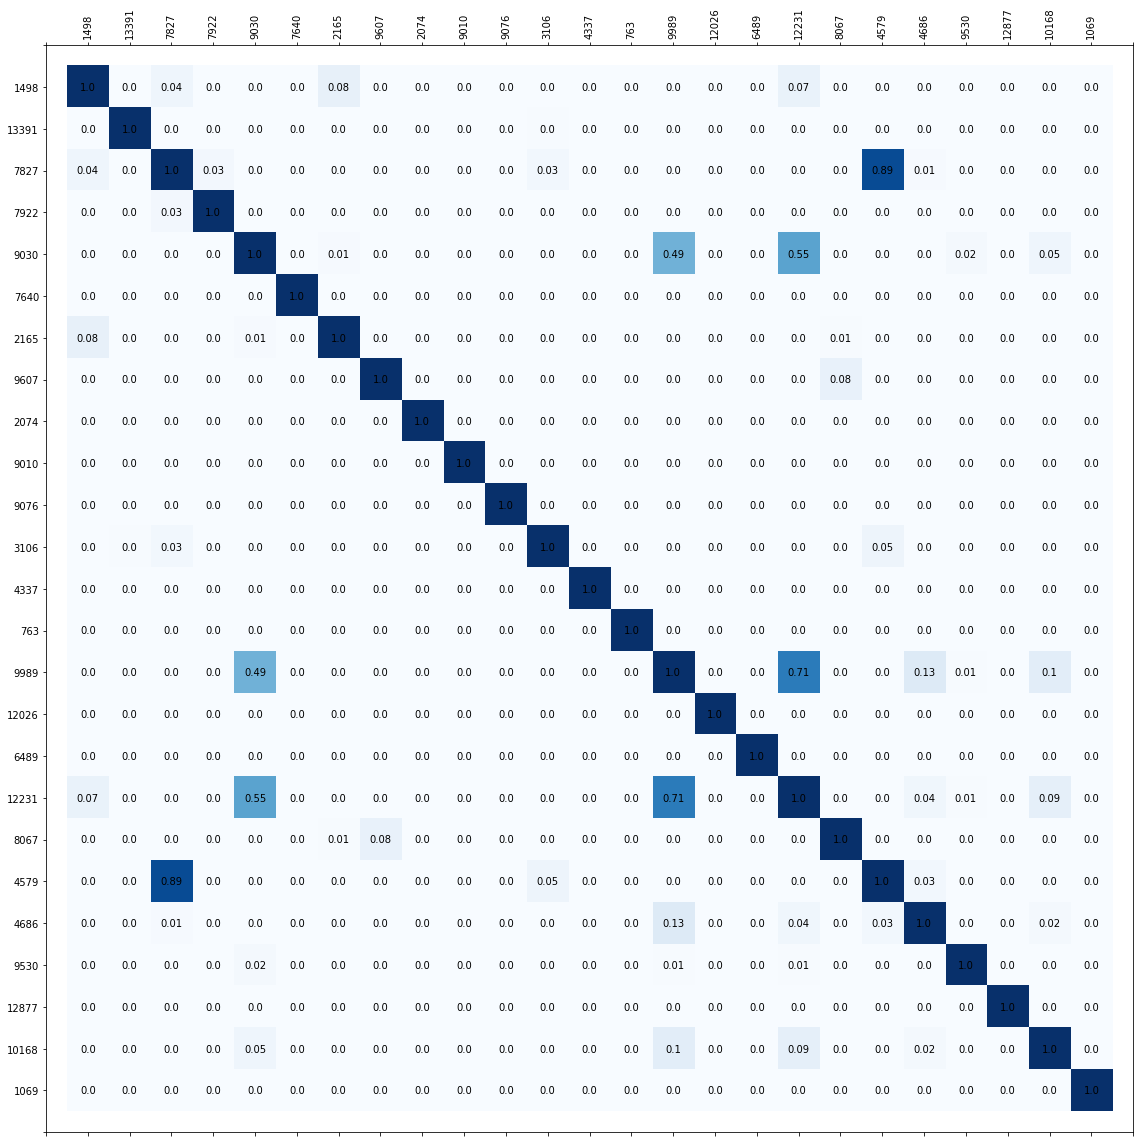

In [17]:
#rand_ids = random.sample(list(helsinki_df["id"]), 25)
rand_ids = [1498, 13391, 7827, 7922, 9030, 7640, 2165, 9607, 
            2074, 9010, 9076, 3106, 4337, 763, 9989, 12026, 6489, 
            12231, 8067, 4579, 4686, 9530, 12877, 10168, 1069]
helsinki_dict = dd.dict_by_ids(helsinki_df, rand_ids)

score_mat_helsinki = dd.similarity_mat(helsinki_dict, ordered = False)
axislabels = list(helsinki_dict.keys())
utils.display_mat(score_mat_helsinki, True, axislabels)

# articles 7827, 4579 are the same article with the exception of an additional few paras
# articles 9030, 9989, 12231 all share copied paragraphs, but also different follow-up paragraphs 


S 5 : I will absolutely bring that up. 

	T 40 0.67 -1.0 : I will absolutely bring that up," Trump told reporters. 

Jaccard Index: 0.6666666666666666 with counts False
I: {'will', 'that', 'absolutely', 'up', 'i', 'bring'}
A-B: set() 
B-A: {'trump', 'tell', 'reporter'}
Entities: 
-1

S 6 : I don't think you'll have any 'Gee, I did it 

	T 41 0.6 -1.0 : I don’t think you’ll 

Jaccard Index: 0.6 with counts False
I: {'will', 'think', 'do', 'i', '-pron-', 'not'}
A-B: {'it', 'gee', 'any', 'have'} 
B-A: set()
Entities: 
-1


0.04427480916030534

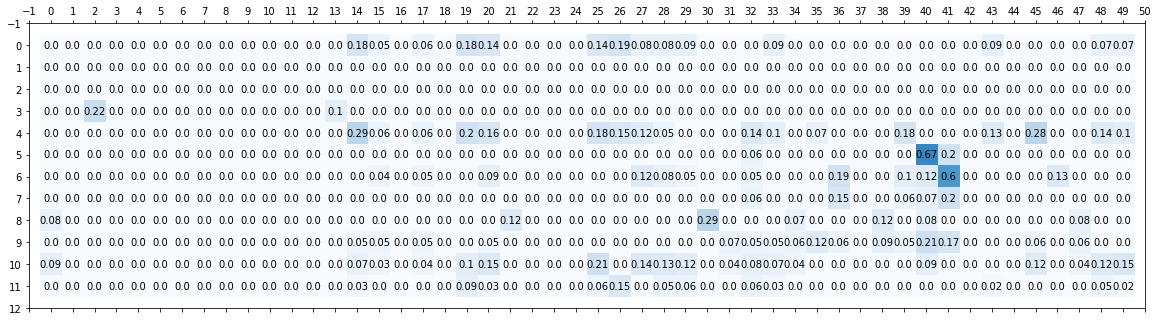

In [18]:
id1 = 1498
id2 = 7827
dd.compute_jaccard_matrix(helsinki_dict[id1], helsinki_dict[id2])
utils.display_mat(dd.get_jaccard_matrix())
dd.print_sentence_matches(visualize=True)
dd.jaccard_score()

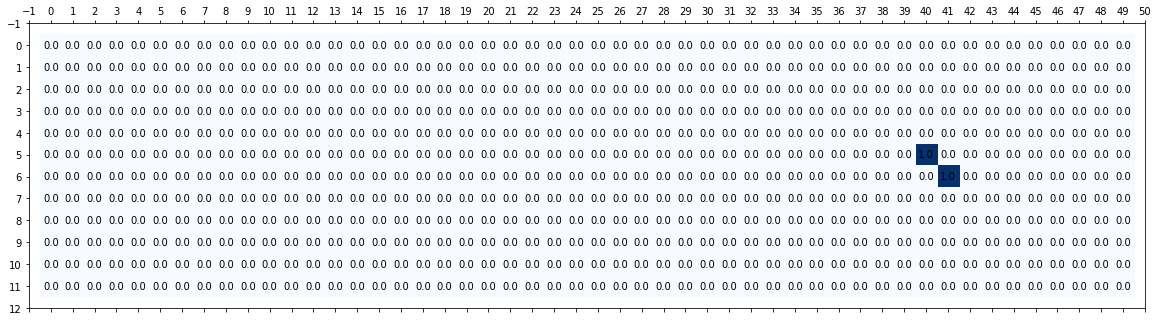

In [19]:
utils.display_mat(1.0 * (dd.get_jaccard_matrix() > 0.5))

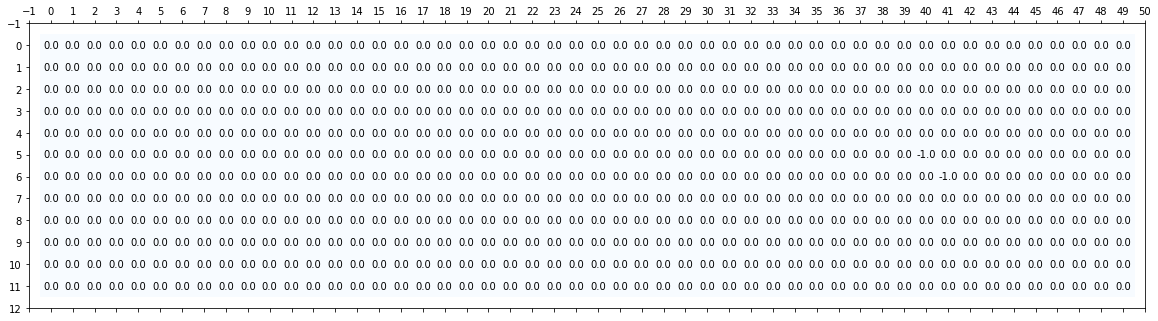

In [20]:
utils.display_mat(dd.entities_mat)

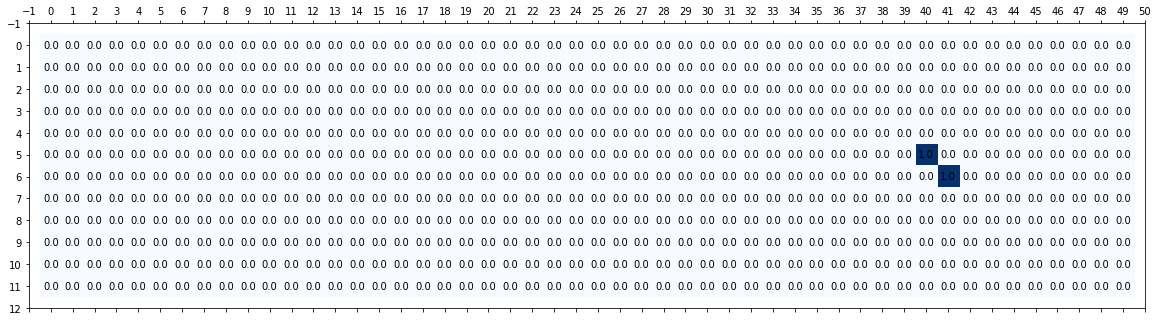

In [21]:
utils.display_mat(dd.get_match_matrix())

Text(0.5, 1.0, 'Probability density histogram of pairwise article similarity scores\n for non-zero similarities')

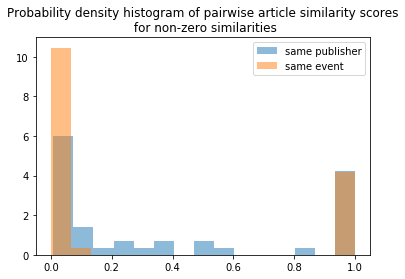

In [22]:
hist(score_mat_dm[np.where(score_mat_dm > 0)])
hist(score_mat_helsinki[np.where(score_mat_dm > 0)])
plt.legend(["same publisher", "same event"])
plt.title("Probability density histogram of pairwise article similarity scores\n for non-zero similarities")

Percentage Unique articles (similarity < 0.25): 0.79
Percentage Unique articles (similarity < 0.75): 0.96


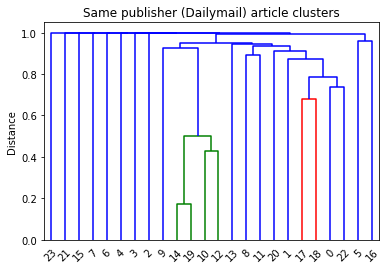

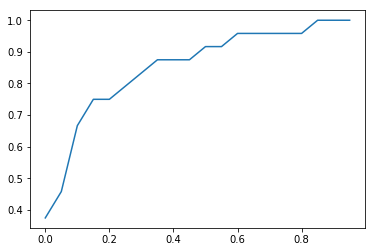

In [23]:
clusts = dd.cluster_articles(score_mat_dm, plot = True)
plt.title("Same publisher (Dailymail) article clusters")

print("Percentage Unique articles (similarity < %.2f): %.2f" % (0.25, dd.prop_unique_clusters(0.25)))
print("Percentage Unique articles (similarity < %.2f): %.2f" % (0.75, dd.prop_unique_clusters(0.75)))
plt.figure()
plt.plot([i/100 for i in range(0, 100, 5)], [dd.prop_unique_clusters(i/100) for i in range(0, 100, 5)])

Percentage Unique articles (similarity < 0.25): 0.88
Percentage Unique articles (similarity < 0.75): 0.96


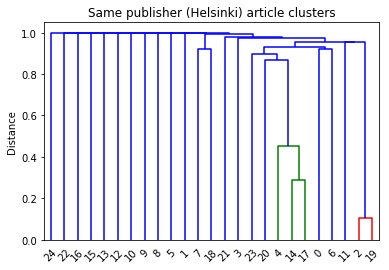

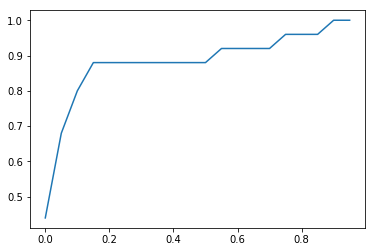

In [24]:
clusts = dd.cluster_articles(score_mat_helsinki, plot = True)
plt.title("Same publisher (Helsinki) article clusters")

print("Percentage Unique articles (similarity < %.2f): %.2f" % (0.25, dd.prop_unique_clusters(0.25)))
print("Percentage Unique articles (similarity < %.2f): %.2f" % (0.75, dd.prop_unique_clusters(0.75)))

plt.figure()
plt.plot([i/100 for i in range(0, 100, 5)], [dd.prop_unique_clusters(i/100) for i in range(0, 100, 5)])